In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pyke.prf import SimpleKeplerPRF

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
prf = SimpleKeplerPRF(channel=16, shape=(11, 11), column=250, row=200)

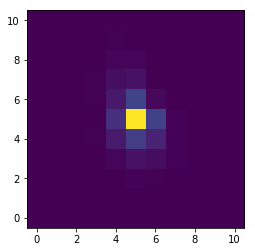

In [4]:
plt.imshow(prf(flux=1e4, center_col=255.5, center_row=205.5), origin='lower')

In [5]:
import numpy as np
from scipy import signal

In [6]:
cadences = np.arange(1000)

In [7]:
A = 1e4 + 1e2 * np.sin(2 * np.pi * np.linspace(0, 6, 1000)) + 300 * np.linspace(0, 1, 1000)
xc = 255.5 + 0.05 * np.random.normal(size=1000) + .3*signal.sawtooth(np.linspace(0, 100, 1000))
yc = 205.5 + 0.05 * np.random.normal(size=1000) + .3 - .3*signal.sawtooth(np.linspace(0, 100, 1000))

In [117]:
tpf = np.array([np.random.poisson(prf(flux=A[i], center_col=xc[i], center_row=yc[i]) + 3) for i in range(1000)], dtype=np.float64)
tpf_save = np.copy(tpf)

In [118]:
tpf[:, 4, 3] = .9 * tpf[:, 4, 3]

In [119]:
tpf[:, 5, 6] = 1.05 * tpf[:, 5, 6]

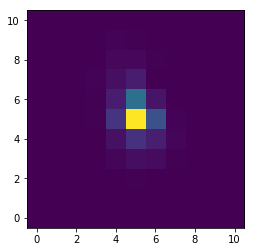

In [120]:
plt.imshow(tpf[100], origin='lower', interpolation='nearest')

In [121]:
true_detector = np.ones(tpf.shape[1:])

In [122]:
true_detector[4, 3] = .9 * true_detector[4, 3]
true_detector[5, 6] = 1.05 * true_detector[5, 6]

In [123]:
true_detector.shape

(11, 11)

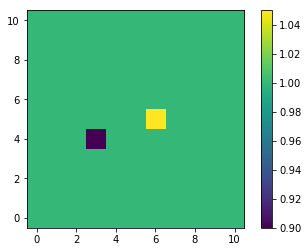

In [124]:
plt.imshow(true_detector, origin='lower')
plt.colorbar()

In [125]:
lc = np.sum(tpf, axis=(1,2))

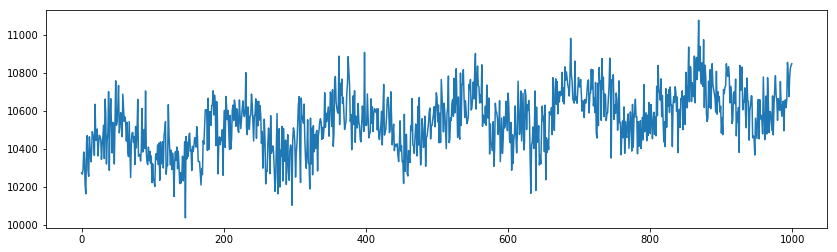

In [126]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, lc)

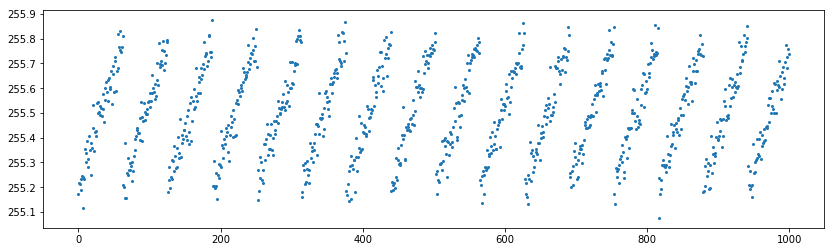

In [127]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xc, 'o', markersize=2)

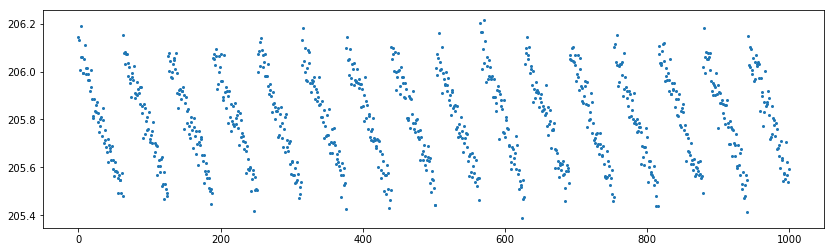

In [128]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, yc, 'o', markersize=2)

In [129]:
from pyke.prf import PRFPhotometry

In [130]:
from oktopus.models import IntegratedSymmetricGaussian2D

In [131]:
from oktopus.prior import UniformPrior

In [132]:
y, x = np.indices(prf.shape) + 0.5

In [133]:
x = x + 250
y = y + 200

In [134]:
psf = IntegratedSymmetricGaussian2D(x, y)

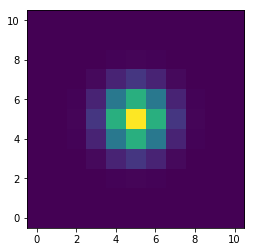

In [135]:
plt.imshow(psf(1000, 255.5, 205.5, 1), origin='lower', interpolation='nearest')

In [136]:
prior = UniformPrior(lb=[5e3, 253.5, 203.5, .25],
                     ub=[15e3, 257.5, 207.5, 1.25])

In [137]:
phot_poisson = PRFPhotometry(scene_model=psf, prior=prior)

In [138]:
results_poisson = phot_poisson.fit(tpf_flux=tpf)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/jvmirca/dev/oktopus/oktopus/likelihood.py:247: RuntimeWarning: invalid value encountered in multiply
  return np.nansum(self.mean(*params) - self.data * np.log(self.mean(*params)))
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 1000/1000 [00:23<00:00, 42.70it/s]


In [139]:
flux = results_poisson[:, 0]
xcenter = results_poisson[:, 1]
ycenter = results_poisson[:, 2]
shape = results_poisson[:, 3]

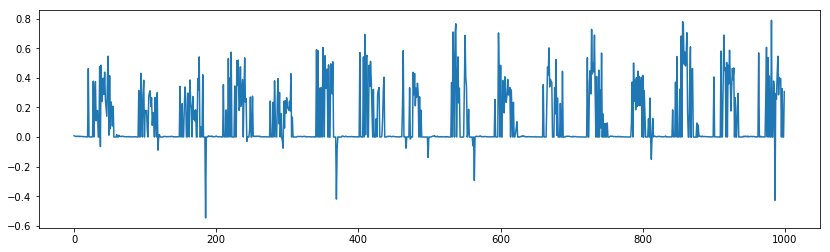

In [140]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, flux - lc)

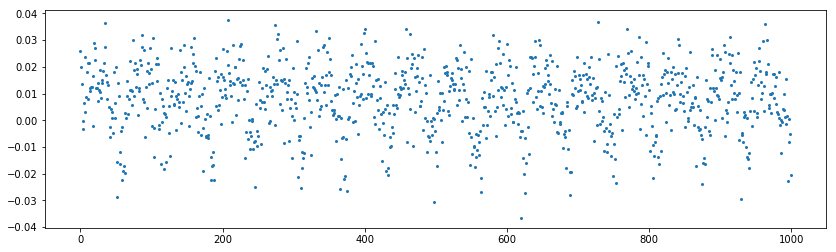

In [141]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xcenter - xc, 'o', markersize=2)

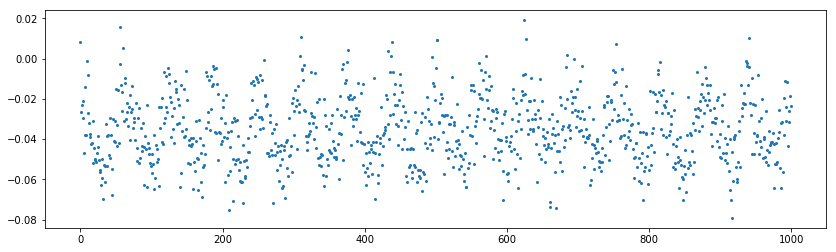

In [142]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, ycenter - yc, 'o', markersize=2)

In [143]:
import numpy as np

In [144]:
x = np.linspace(0, 10, 11)

In [145]:
y = np.linspace(0, 10, 11)

In [146]:
xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [147]:
from scipy.interpolate import RectBivariateSpline

In [148]:
tpf += true_detector

In [149]:
tpf = np.log(tpf)

In [150]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]

In [151]:
super_tpf = np.array([interp[i](yp + (yc[i] - 205.5), xp + (xc[i] - 255.5)) for i in range(len(xc))])

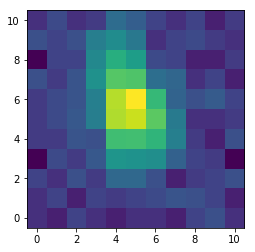

In [152]:
plt.imshow(tpf[1], origin='lower', interpolation='nearest')

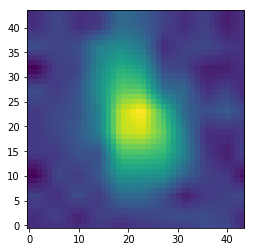

In [153]:
plt.imshow(super_tpf[1], origin='lower', interpolation='nearest')

In [154]:
mean_super_tpf = np.mean(super_tpf, axis=0)

In [155]:
mean_super_tpf.shape

(44, 44)

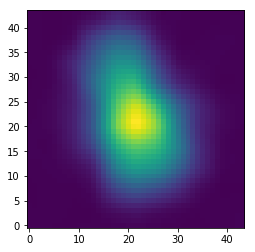

In [156]:
plt.imshow(mean_super_tpf, origin='lower', interpolation='nearest')

In [157]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

In [158]:
detector = np.zeros((44,44))

In [159]:
np.sum(norm_super_tpf)

0.99999999999999989

In [160]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx) + detector

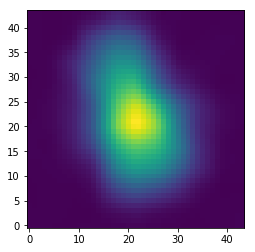

In [161]:
plt.imshow(model_prime(10, 0, 0, norm_super_tpf), origin='lower', interpolation='nearest')

In [162]:
np.sum(model_prime(10, 0, 0, norm_super_tpf))

10.0

In [163]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))

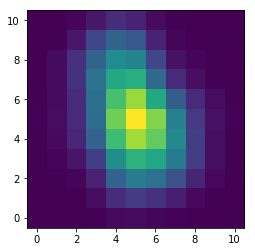

In [164]:
plt.imshow(model(10, 0, 0, norm_super_tpf), origin='lower', interpolation='nearest')

In [165]:
np.sum(model(10, 0, 0, norm_super_tpf))

10.0

In [166]:
detector = np.zeros((44, 44))

In [167]:
data = tpf[0]

In [168]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s) + model(1, 0, 0, template_d) - self.data
        return np.sum(r * r)

In [169]:
from scipy.optimize import minimize

In [170]:
from tqdm import tqdm

In [171]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(np.log(1e4), 0, 0), args=(norm_super_tpf, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]


In [172]:
results = np.array(results)

In [173]:
results.shape

(1000, 3)

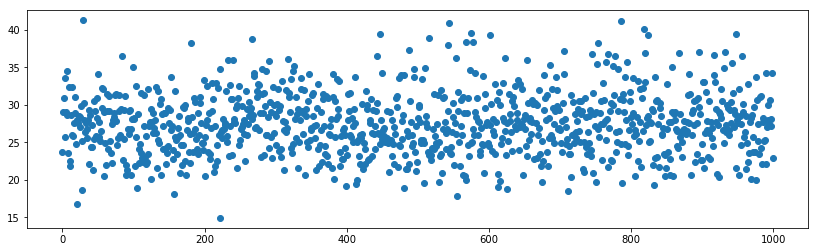

In [174]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [175]:
xc[0] - 255.5

-0.32696831626378753

In [176]:
yc[0] - 205.5

0.64484549982307726

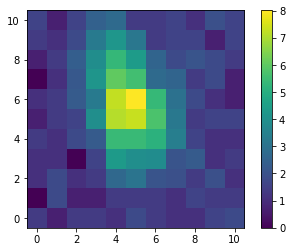

In [177]:
plt.imshow(tpf[0], origin='lower', interpolation='nearest')
plt.colorbar()

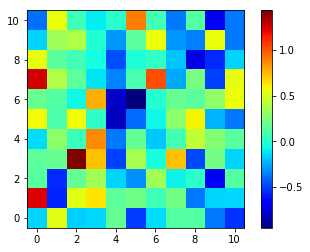

In [178]:
model_ = model(*results[0], norm_super_tpf)
plt.imshow(model_ - tpf[0], origin='lower', interpolation='nearest', cmap='jet')
plt.colorbar()

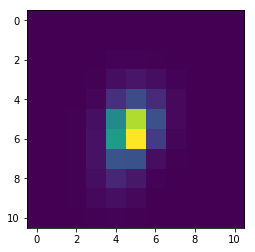

In [179]:
plt.imshow(np.exp(model_), interpolation='nearest')

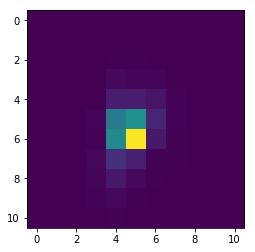

In [180]:
plt.imshow(np.exp(tpf[0]), interpolation='nearest')

In [181]:
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [182]:
models = [model(*results[i], norm_super_tpf) for i in range(1000)]
interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]

In [183]:
dlnlike_ds = 2 * np.array([results[i, 0] * interps[i](yp - results[i, 1], xp - results[i, 2]) for i in range(1000)])

In [184]:
dlnlike_ds.shape

(1000, 44, 44)

In [185]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

In [186]:
dlnlike_ds.shape

(44, 44)

In [187]:
dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])

In [188]:
dlnlike_dd = np.sum(dlnlike_dd, axis=0)

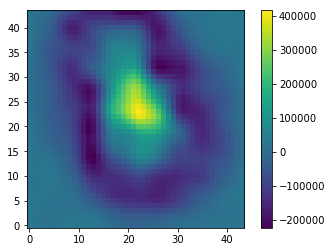

In [189]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

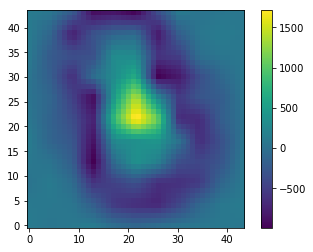

In [190]:
plt.imshow(-dlnlike_dd, origin='lower', interpolation='nearest')
plt.colorbar()

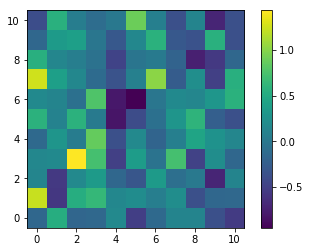

In [191]:
plt.imshow(models[0] - tpf[0], origin='lower')
plt.colorbar()

In [192]:
dlnlike_ds.shape

(44, 44)

In [193]:
gds = np.copy(norm_super_tpf)

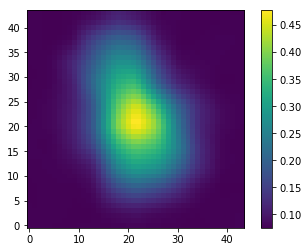

In [194]:
plt.imshow(results[0, 0] * gds, origin='lower', interpolation='nearest')
plt.colorbar()

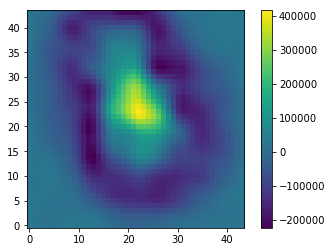

In [195]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [196]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-12
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    while j < 2000:
        logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                              for i in range(1000)])
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
        interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
        dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
        dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if (logL_before - logL_after) / logL_before < 1e-6:
            break
        j += 1
    return tmp_s

In [197]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-9
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    while j < 2000:
        logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
        interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
        dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
        dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if (logL_before - logL_after) / logL_before < 1e-6:
            break
        j += 1
    return tmp_d

In [198]:
gdd=detector

In [199]:
np.sum(detector)

0.0

In [200]:
gds = gradient_descent_ds(gds, gdd, (results[:, 0], results[:, 1], results[:, 2]))
gds = gds / np.sum(gds)

27492.292988
27472.3047424
27472.3047424
27450.4018411
27450.4018411
27426.4100825
27426.4100825
27400.1413368
27400.1413368
27371.3928426
27371.3928426
27339.9465654
27339.9465654
27305.5686456
27305.5686456
27268.0089725
27268.0089725
27227.000927
27227.000927
27182.2613458
27182.2613458
27133.4907664
27133.4907664
27080.374027
27080.374027
27022.581303
27022.581303
26959.7696765
26959.7696765
26891.5853486
26891.5853486
26817.6666131
26817.6666131
26737.6477287
26737.6477287
26651.1638292
26651.1638292
26557.8570258
26557.8570258
26457.3838505
26457.3838505
26349.4241907
26349.4241907
26233.6918443
26233.6918443
26109.9467987
26109.9467987
25978.0092916
25978.0092916
25837.7756415
25837.7756415
25689.2357456
25689.2357456
25532.4920194
25532.4920194
25367.7793994
25367.7793994
25195.4858423
25195.4858423
25016.172541
25016.172541
24830.5928368
24830.5928368
24639.7085658
24639.7085658
24444.7023485
24444.7023485
24246.9841536
24246.9841536
24048.1903907
24048.1903907
23850.1738555
2

In [201]:
gdd = gradient_descent_dd(gds, gdd, (results[:, 0], results[:, 1], results[:, 2]))

23020.2226207
23020.1392449
23020.1392449
23020.0475365
23020.0475365
23019.9466632
23019.9466632
23019.8357099
23019.8357099
23019.7136701
23019.7136701
23019.579437
23019.579437
23019.4317935
23019.4317935
23019.2694012
23019.2694012
23019.0907886
23019.0907886
23018.8943375
23018.8943375
23018.678269
23018.678269
23018.4406271
23018.4406271
23018.1792615
23018.1792615
23017.8918082
23017.8918082
23017.5756688
23017.5756688
23017.2279871
23017.2279871
23016.8456239
23016.8456239
23016.4251292
23016.4251292
23015.9627119
23015.9627119
23015.4542062
23015.4542062
23014.8950354
23014.8950354
23014.280172
23014.280172
23013.6040936
23013.6040936
23012.8607357
23012.8607357
23012.0434389
23012.0434389
23011.1448927
23011.1448927
23010.1570723
23010.1570723
23009.071172
23009.071172
23007.8775305
23007.8775305
23006.565551
23006.565551
23005.1236144
23005.1236144
23003.5389838
23003.5389838
23001.7977029
23001.7977029
22999.8844848
22999.8844848
22997.7825925
22997.7825925
22995.4737097
22

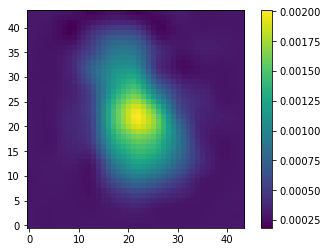

In [202]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

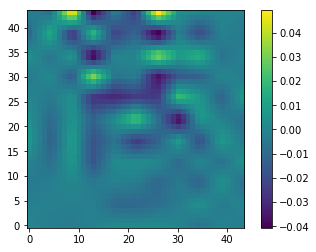

In [203]:
plt.imshow(gdd, origin='lower', interpolation='nearest')
plt.colorbar()

In [204]:
np.sum(gds)

1.0

In [205]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

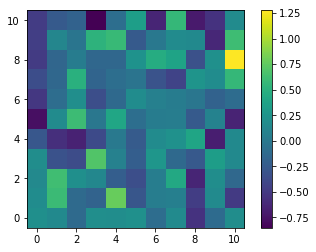

In [216]:
n=-1
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) + model(1, 0, 0, gdd) - tpf[n], origin='lower', interpolation='nearest')
plt.colorbar()

In [207]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, gdd), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:38<00:00, 23.92it/s]


In [208]:
results = np.array(results)

In [209]:
results.shape

(1000, 3)

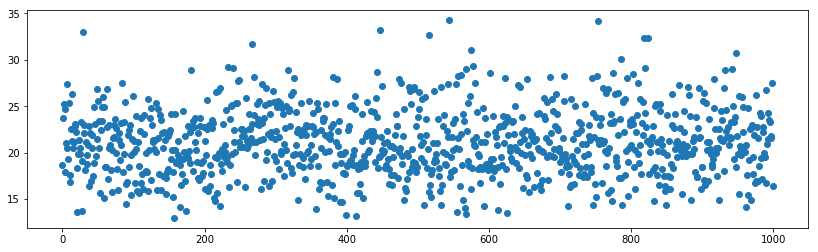

In [210]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [211]:
gds = gradient_descent_ds(gds, gdd, (results[:, 0], results[:, 1], results[:, 2]))
gds = gds/np.sum(gds)

21103.0330731
21103.1969255


In [212]:
gdd = gradient_descent_dd(gds, gdd, (results[:, 0], results[:, 1], results[:, 2]))

21103.1969211
21103.1967205


In [213]:
results = np.array(results)
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

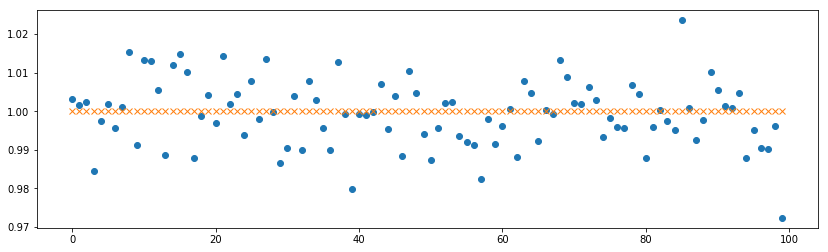

In [226]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(100), f_n[:100]/np.mean(f_n), 'o')
plt.plot(np.arange(100), np.sum((tpf_save[:100]), axis=(1, 2))/np.sum((tpf_save[:100]), axis=(1, 2)), 'x')

In [215]:
true_detector

array([[ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  0.9 ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.05,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.

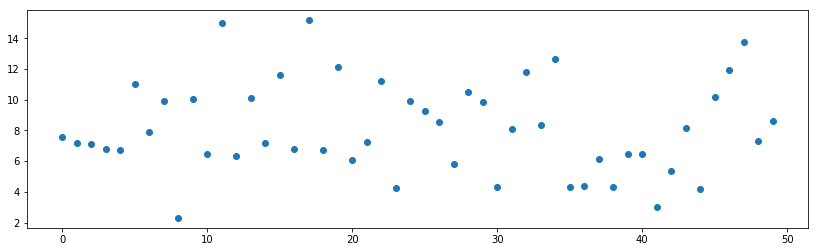

In [356]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(50), f_n - np.sum(tpf[:50], axis=(1, 2)), 'o')

In [116]:
np.sum(tpf[0])

10331.6